In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import geopandas
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
from torchvision import transforms

import warnings
import random
import time

In [2]:
!pwd

/home/simon/CDE_UBS/thesis/data_loader


In [3]:
# inputs
spot6_mosaic = '/home/simon/CDE_UBS/thesis/data_collection/spot6/spot6_mosaic.tif'
spot6_path = "/home/simon/CDE_UBS/thesis/data_collection/spot6/"
sen2_path = "/home/simon/CDE_UBS/thesis/data_collection/sen2/merged_reprojected/"
closest_dates_filepath = "/home/simon/CDE_UBS/thesis/data_loader/data/closest_dates.pkl"
#train_test_split_filepath = 

In [4]:
# Define torch dataset Class
class Dataset(Dataset):
    def __init__(self,spot6_mosaic,sen2_path,spot6_path,closest_dates_filepath,window_size=500,factor=(10/1.5),clip=True,temporal_images=1):
        
        # define filepaths
        self.temporal_images = temporal_images
        self.closest_dates_filepath = closest_dates_filepath
        self.spot6_mosaic = spot6_mosaic
        self.sen2_path = sen2_path
        self.spot6_path = spot6_path
        
        # define window size
        self.window_size = window_size
        self.factor = factor
        self.window_size_sen2 = int(window_size/self.factor)
        
        # define transformer
        self.transform_sen  = transforms.Compose([
            transforms.Normalize(mean=[479.0, 537.0, 344.0], std=[430.0, 290.0, 229.0]) ])
        self.transform_spot = transforms.Compose([
            transforms.Normalize(mean=[78.0, 91.0, 62.0], std=[36.0, 28.0, 30.0]) ])
        
        
        # Get DF from create_data function!
        try:
            self.coordinates_closest_date_valid = pd.read_pickle("final_dataset.pkl")
            print("precalculated dataset file found, loading...")
        except FileNotFoundError:
            print("No precalculated dataset file found -> calling builder function!")
            from prepare_dataset import prepare_dataset
            self.coordinates_closest_date_valid = prepare_dataset(
                spot6_mosaic,sen2_path,spot6_path,closest_dates_filepath,
                window_size=500,factor=(10/1.5),clip=True,temporal_images=1)
        
        # delete invalid spot6 rows, reset index of df
        self.coordinates_closest_date_valid = self.coordinates_closest_date_valid[self.coordinates_closest_date_valid["spot6_validity"]==True]
        self.coordinates_closest_date_valid = self.coordinates_closest_date_valid.reset_index()
        
        # reset coordinates based on manipulated coordinates datasets
        tmp_coordinates = []
        for x,y in zip(self.coordinates_closest_date_valid["x"],self.coordinates_closest_date_valid["y"]):
            tmp_coordinates.append((x,y))
        self.coordinates = tmp_coordinates
        
        print("\nDataset Object successfully instanciated!")
 
    def __len__(self):
        """
        Returns length of data
        """
        return(len(self.coordinates_closest_date_valid))
 
    def __getitem__(self,idx):
        """
        Input:
            - id of item
        Output:
            - x and y images as np arrays
        """
        get_from_mosaic = False # set wether window should be taken from mosaic or individual spot6 files
        
        
        import time
        start_total = time.time()
        
        
        # extract coordinates of current request
        current_coor = self.coordinates[idx]
        current_coor_df = self.coordinates_closest_date_valid.loc[(self.coordinates_closest_date_valid["x"]==current_coor[0]) 
                                                                     & (self.coordinates_closest_date_valid["y"]==current_coor[1])]
        
        # load spot6 window by singular image
        if get_from_mosaic == False:
            start_spot6 = time.time()
            current_spot6_path = spot6_path + current_coor_df["name"][current_coor_df.index[0]]
            im_spot6 = Dataset.extract_spot6_window(current_spot6_path,coordinates=current_coor,window_size=self.window_size)
            end_spot6 = time.time()
        if get_from_mosaic == True:
            start_spot6 = time.time()
            im_spot6 = Dataset.extract_spot6_window(self.spot6_mosaic,coordinates=current_coor,window_size=self.window_size)
            end_spot6 = time.time()
        
        start_sen2 = time.time()
        # load sen2 window
        current_dict = current_coor_df["other_valid_acq"][current_coor_df.index[0]] # extract current dict
        im_sen2 = Dataset.extract_sen2_window(Dataset.get_valid_sen2paths(current_dict,sen2_path),current_coor,self.window_size_sen2)
        while type(im_sen2)==str: # if unecpected error, return random other image
            current_coor = self.coordinates[idx+random.randint(0,len(self.coordinates))]
            current_coor_df = self.coordinates_closest_date_valid.loc[(self.coordinates_closest_date_valid["x"]==current_coor[0]) 
                                                                    & (self.coordinates_closest_date_valid["y"]==current_coor[1])]
            current_dict = current_coor_df["other_valid_acq"][current_coor_df.index[0]] # extract current dict
            im_sen2 = Dataset.extract_sen2_window(Dataset.get_valid_sen2paths(current_dict,sen2_path),current_coor,self.window_size_sen2)
            print("ERROR ITERATION")
        end_sen2 = time.time()
        
        
        end_total = time.time()
        #print("Total Time: ",end_total-start_total)
        #print("Spot6 Time: ",end_spot6-start_spot6)
        #print("Sen2 Time: ",end_sen2-start_sen2)
        # return extracted images
        
        
        """ CHECK FOR VALIDITY OF IMAGE SHAPES"""
        
        if im_spot6.shape != (3,self.window_size,self.window_size):
            warnings.warn("Warning in Dataloader: SPOT6 Window shape not valid at coordinates: "+str(current_coor)+" - Shape: "+str(im_spot6.shape))
        if im_sen2.shape != (3,self.window_size_sen2,self.window_size_sen2):
            warnings.warn("Warning in Dataloader: Sen-2 Window shape not valid at coordinates: "+str(current_coor)+" - Shape: "+str(im_sen2.shape))
        
        # Perform Transform and change types
        im_sen2  = torch.from_numpy(im_sen2)
        im_spot6 = torch.from_numpy(im_spot6)
        
        im_sen2 = im_sen2.float()
        im_spot6 = im_spot6.float()
        
        im_sen2  = self.transform_sen(im_sen2)
        im_spot6 = self.transform_spot(im_spot6)
        
        return(im_spot6,im_sen2)



    def extract_spot6_window(filepath,coordinates,window_size=500,show=False):
        """
        Inputs:
            - filepath of mosaic raster
            - point coordinates of window
            - window size in pixels
        Outputs:
            - window array from input mosaic at desired location
        
        """
        import rasterio
        import numpy as np

        # if coordinates == singular tuple of coordinates, wrap it in list
        if type(coordinates)!=list:
            coordinates = [coordinates]

        with rasterio.open(filepath) as dataset:
            # Loop through your list of coords
            for i, (lon, lat) in enumerate(coordinates):

                # Get pixel coordinates from map coordinates
                py, px = dataset.index(lon, lat)
                #print('Pixel Y, X coords: {}, {}'.format(py, px))

                # Build an NxN window (centered)
                window = rasterio.windows.Window(px - window_size//2, py - window_size//2, window_size, window_size)
                #print(window)

                # Read the data in the window
                # clip is a nbands * N * N numpy array
                clip = dataset.read(window=window)

                if show:
                    if clip.shape == (3, window_size, window_size):
                        image_standard_form = np.transpose(clip, (2, 1, 0))
                        plt.imshow(image_standard_form)
                        plt.show()
                    else:
                        print("Shape invalid - most likely edge window")

        return(clip)
 
    
    def extract_sen2_window(path_list,coordinates,window_size):
        """
        Inputs:
            - filepath of spot6 files
            - point coordinates of window as tuples
            - window size in pixels
        Outputs:
            - window array from input mosaic at desired location
        
        """
        import rasterio
        import numpy as np
        show=False # Show result?

        # extract coordinates
        lon,lat = coordinates[0],coordinates[1]
        # loop over list of acq.
        for file_path in path_list:
            # open file
            with rasterio.open(file_path) as dataset:
                # get pixel coordinates
                py,px = dataset.index(lon, lat)
                # build and read window
                window = rasterio.windows.Window(px - window_size//2, py - window_size//2, window_size, window_size)
                clip = dataset.read(window=window)

                # if wanted, show image
                if show:
                        if clip.shape == (3, window_size, window_size):
                            image_standard_form = np.transpose(clip, (2, 1, 0))
                            plt.imshow(image_standard_form)
                            plt.show()
                        else:
                            print("Shape invalid - most likely edge window")
        return(clip)
    
    def get_valid_sen2paths(acq_dict_sen2,path,num_images=1):
        dates = list(acq_dict_sen2.keys()) # get keys ergo closest times
        dates.sort() # sort so lowest can be accessed

        valid_files = []
        count=0
        count_true = 0
        for v,i in enumerate(dates): # iterate over closest
            if count_true==num_images: # stop while loop if number of required images is extracted
                #print("all extracted")
                break

            if acq_dict_sen2[i][2]==True:
                count_true=count_true+1
                filepath = acq_dict_sen2[i][1]
                valid_files.append(filepath)

            # protection for if more images requested than available
            if v==len(dates)-1:
                warnings.warn("WARNING: More image aqc. dates requested than available. Recalculate full validity dataframe or request fewer sen2 images!")
                break

        for v,i in enumerate(valid_files):
            valid_files[v] = path + valid_files[v]
        return(valid_files)




In [5]:
instanciate_locally = True
if instanciate_locally:
    # Instanciate dataset object
    dataset = Dataset(spot6_mosaic,sen2_path,spot6_path,closest_dates_filepath,window_size=500,factor=(10/1.5))

    # Instanciate dataloader object
    loader = DataLoader(dataset,batch_size=1, shuffle=True, num_workers=1)
    print("Loader Length: ",len(loader))

No precalculated dataset file found -> calling builder function!
Full dataset not found, recalculating from scratch. This might take up to 12 hrs, depending on the availability of the Sen2/Spot6 validity files.


Performing clip of window corner points to valid raster values!
loading points into gdf...
verifying points on raster...
dropping invalid points...
clipping done!                        

Getting closest dates!
create closest dates gdf...
create coordinates gdf...
performing spatial join...
done


Checking Sen2 validity for all windows & acquisitions - might take several hours
Precalculated File found - no recalculation necessary!

Dataset successfully prepared!
Fully computed dataset found, no calculations necesary!

Dataset successfully prepared!

Dataset Object successfully instanciated!
Loader Length:  82599


In [6]:
a = pd.read_pickle("final_dataset.pkl")

<AxesSubplot:>

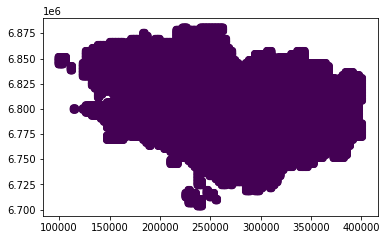

In [7]:
a.plot(column="spot6_validity")

In [8]:
a["spot6_validity"].value_counts()

True    82599
Name: spot6_validity, dtype: int64

In [ ]:
a.to_csv("export_NEW.csv")

In [ ]:
print_some_images = True

if print_some_images:
    
    # TEST TIME
    for i in range(0,20):
        start = time.time()
        a,b = dataset.__getitem__(random.randint(0,len(loader)))
        end = time.time()
        print("Elapsed time: ",round(end-start,3))

    
    
    # LOOK AT SOME IMAGES
    def plot_images(a,b,title):
        import matplotlib.pyplot as plt
        import numpy as np
        from torchvision.transforms import ToPILImage


        a = np.transpose(a,(1,2,0))
        b = np.transpose(b,(1,2,0))

        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
        fig.suptitle('Spot6 vs Sen2 - time to fetch: '+str(title))
        ax1.imshow(a)
        ax2.imshow(b)
        plt.show()


    for i in range(0,10):
        start=time.time()
        a,b = dataset.__getitem__(random.randint(0,len(loader)))
        end=time.time()

        plot_images(a,b,round(end-start,3))


In [ ]:
a

In [ ]:

d1 = pd.read_pickle("final_dataset.pkl")

In [ ]:
d1[d1["spot6_validity"]==True].count()

In [ ]:
d1.to_csv("1.csv")